In [61]:
%reload_ext autoreload
%autoreload 2
from psypose.extract import annotate
from psypose.data import pose
from psypose.pose_estimation_with_pyfeat import estimate_pose
from pathlib import Path
import subprocess
from moviepy.editor import VideoFileClip
import os.path as osp
import joblib
from psypose import display
from psypose import utils as putils
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from PIL import Image
from tqdm import tqdm

In [2]:
def trim_video(posix_video_path, start_time, end_time, output_path):
    """
    Takes a posix path to a video file, a start trim value (in seconds), an end trim value (in seconds), and an output path.
    Trims the video and saves it to the output path.
    """
    stringPath = str(posix_video_path)
    duration = VideoFileClip(stringPath).duration
    ffmpeg_command = f'ffmpeg -i {stringPath} -ss {start_time} -to {end_time} -c copy {output_path}'
    subprocess.run(ffmpeg_command, shell=True)
    return output_path

In [3]:
videopath = Path('/media/landry/fastscratch/landry_dev_scratch/2023-10-06_000/derivatives')
testpath = videopath / '../..'/ 'test_outputs'
testpath.mkdir(exist_ok=True)
tvids = [str(i) for i in videopath.glob('*trimmed*.mp4')]
tvids

['/media/landry/fastscratch/landry_dev_scratch/2023-10-06_000/derivatives/cam2_concatenated_trimmed.mp4',
 '/media/landry/fastscratch/landry_dev_scratch/2023-10-06_000/derivatives/cam1_concatenated_trimmed.mp4']

In [5]:
# trim the video down 
# trimmed_vid = Path(trim_video(tvids[1], (23*60)+25, (23*60)+52, str(testpath / osp.basename(tvids[1].replace('.mp4', '_trimmed_test.mp4')))))

In [14]:
# cam2 = pose()
# cam2.load_video('/media/landry/fastscratch/landry_dev_scratch/test_outputs/cam1_concatenated_trimmed_trimmed_test.mp4')
# cam2.vid_path
# cam2.output_path = testpath
# cam2.no_render = False
# cam2.smooth = False

In [16]:
cam2 = pose()
cam2.load_video('/media/landry/fastscratch/landry_dev_scratch/test_outputs/cam1_concatenated_trimmed_trimmed_test.mp4')
cam2.vid_path
cam2.output_path = testpath
cam2.pose_data = joblib.load('/media/landry/fastscratch/landry_dev_scratch/test_outputs/cam2_concatenated_trimmed_trimmed_test.pkl')

In [17]:
# results = estimate_pose(cam2)
# cam2.pose_data = results

In [8]:
def extract_body_image(array, data, downsample=True):
    """
    Given an image in the form of a numpy array and a bounding box, returns the cropped body.
    @param array: Numpy array representing video frame.
    @type array: numpy.ndarray
    @param data: Bounding box [cx, cy, w, h]
    @type data: list
    @param downsample: Whether to normalize to 100x100 pixels
    @type downsample: bool
    @return: Cropped image as numpy array
    @rtype: numpy.ndarray
    """
    # This takes an image in numpy format and a body bbox, crops the image, and scales it down to 100x100
    abs_h, abs_w = array.shape[0], array.shape[1]
    cx, cy, w, h = [i for i in data]
    # this 
    top, right, bottom, left = [int(round(i)) for i in [(cy-h/2), int(cx+w/2), int(cy+h/2), (cx-w/2)]]

    # Padding images with black if the bbox is out-of-frame

    if right > abs_w:
      r_overhang = right-round(abs_w) + 10
      array = np.pad(array, ((0,r_overhang),(0,0),(0,0)))
    if left < 0:
      l_overhang = -1*left
      right-=left
      left = 0
      array = np.pad(array, ((l_overhang,0),(0,0),(0,0)))
    if bottom > abs_h:
      b_overhang = bottom-round(abs_h) + 10
      array = np.pad(array, ((0,0),(0,b_overhang),(0,0)))
    if top < 0:
      t_overhang = -1*top
      bottom-=top
      top=0
      array = np.pad(array, ((0,0),(t_overhang,0),(0,0)))

    new_img = array[top:bottom, left:right, :]
    return new_img

In [9]:
def get_bbox_indices(bbox):
    """
    Given an image in the form of a numpy array and a bounding box, returns the cropped body.
    @param array: Numpy array representing video frame.
    @type array: numpy.ndarray
    @param data: Bounding box [cx, cy, w, h]
    @type data: list
    @param downsample: Whether to normalize to 100x100 pixels
    @type downsample: bool
    @return: Cropped image as numpy array
    @rtype: numpy.ndarray
    """
    # This takes an image in numpy format and a body bbox, crops the image, and scales it down to 100x100
    cx, cy, w, h = [i for i in bbox]
    # this 
    top, right, bottom, left = [int(round(i)) for i in [(cy-h/2), int(cx+w/2), int(cy+h/2), (cx-w/2)]]

    return [top, bottom, left, right]

In [12]:
# Now integrating some pyfeat stuffs
frame = 300
person = 1
img = putils.frame2array(frame, cam2.vid_cv2)
# get bbox for this frame
bbox = cam2.pose_data[person]['bboxes'][frame]
print(bbox)
# bbox is top, right, bottom, left
img_crop = extract_body_image(img, bbox)
bbox_indices = get_bbox_indices(bbox)

[1278.4932691   516.59474507  679.23654249  679.23654249]


In [18]:
# Now integrating some pyfeat stuffs
frame = 900
img = putils.frame2array(frame, cam2.vid_cv2)
# get bbox for this frame
bbox_0 = cam2.pose_data[0]['bboxes'][frame]
bbox_1 = cam2.pose_data[1]['bboxes'][frame]
# bbox is top, right, bottom, left
bbox_indices0 = get_bbox_indices(bbox_0)
bbox_indices1 = get_bbox_indices(bbox_1)

# plot image with bbox on top
fig = px.imshow(img)


# plot a point at the head for person 0
fig.add_shape(type="rect",
              x0=bbox_indices0[2], y0=bbox_indices0[0], x1=bbox_indices0[3], y1=bbox_indices0[1],
              line=dict(color="Red",width=2))
headx, heady = cam2.pose_data[0]['smpl_joints2d'][frame][15]
fig.add_trace(go.Scatter(x=[headx], y=[heady], mode='markers', marker=dict(size=10, color='red')))
# generate bbox around head point based on the head joint (make top, right, botom, left)
head_bbox = [heady-100, headx+100, heady+100, headx-100]
fig.add_shape(type="rect",
              x0=head_bbox[3], y0=head_bbox[0], x1=head_bbox[1], y1=head_bbox[2],
              line=dict(color="Red",width=2))



# plot a point at the head for person 1
fig.add_shape(type="rect",
              x0=bbox_indices1[2], y0=bbox_indices1[0], x1=bbox_indices1[3], y1=bbox_indices1[1],
              line=dict(color="Blue",width=2))
headx, heady = cam2.pose_data[1]['smpl_joints2d'][frame][15]
fig.add_trace(go.Scatter(x=[headx], y=[heady], mode='markers', marker=dict(size=10, color='blue')))
# generate bbox around head point based on the head joint (make top, right, botom, left)
head_bbox = [heady-100, headx+100, heady+100, headx-100]
fig.add_shape(type="rect",
              x0=head_bbox[3], y0=head_bbox[0], x1=head_bbox[1], y1=head_bbox[2],
              line=dict(color="Blue",width=2))


In [57]:
def get_face(joints2d_frame):
    head = joints2d_frame[15]
    face_bbox = [head[0]-100, head[1]+100, head[0]+100, head[1]-100]
    face_bbox = [int(round(i)) for i in face_bbox]
    # returns top, right, bottom, left
    # use these as indices for cropping a face image in the form of a numpy array
    return face_bbox

def add_faces(pose_data):
    for person, data in pose_data.items():
        pose_data[person]['face'] = {}
        bboxes = []
        for frame, joints2d in enumerate(data['smpl_joints2d']):
            bboxes.append(get_face(joints2d))
        pose_data[person]['face']['bbox'] = np.array(bboxes)

add_faces(cam2.pose_data)

cam2.pose_data[0]['face']['bbox'][0]

array([422, 315, 622, 115])

In [58]:
img_path = Path('/media/landry/fastscratch/landry_dev_scratch/test_outputs/vframes')
cam2.pose_data[0]['frame_ids']

array([   0,    1,    2, ..., 1616, 1617, 1618])

426 313 626 113


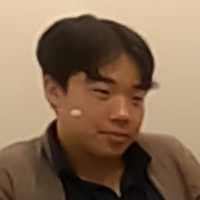

In [60]:
# get a face image by getting the right png, reading it, and cropping it
frame = 300
person = 0
img = Image.open(img_path / f'{frame:06d}.png')
top, right, bottom, left = cam2.pose_data[person]['face']['bbox'][frame] # top, right, bottom, left
print(top, right, bottom, left)
face_img = np.array(img)[left:right, top:bottom, :]
Image.fromarray(face_img)

In [64]:
# make a face image folder and save all the face images
face_img_path = Path('/media/landry/fastscratch/landry_dev_scratch/test_outputs/face_images')
face_img_path.mkdir(exist_ok=True)
for frame in tqdm(cam2.pose_data[0]['frame_ids']):
    frame+=1
    if frame==len(cam2.pose_data[0]['frame_ids']):
        break
    img = Image.open(img_path / f'{frame:06d}.png')
    top, right, bottom, left = cam2.pose_data[person]['face']['bbox'][frame] # top, right, bottom, left
    face_img = np.array(img)[left:right, top:bottom, :]
    Image.fromarray(face_img).save(face_img_path / f'{frame:06d}.png')

100%|██████████| 1619/1619 [00:00<00:00, 3266271.37it/s]


# Run Pose Estimation on all the full videos

In [3]:
videopath = Path('/safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives')
videos = [str(i) for i in videopath.glob('*_concatenated_trimmed.mp4')]
videos

['/safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives/cam1_concatenated_trimmed.mp4',
 '/safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives/cam2_concatenated_trimmed.mp4']

In [4]:
for video in videos:
    v = pose()
    v.load_video(video)
    v.output_path = videopath
    v.no_render = True
    v.no_save = False
    results = estimate_pose(v)

Running "ffmpeg -i /safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives/cam1_concatenated_trimmed.mp4 -f image2 -v error /safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives/cam1_concatenated_trimmed_frames/%06d.png"
Images saved to "/safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives/cam1_concatenated_trimmed_frames"


2023-09-28 11:54:47.749 | INFO     | psypose.pose_estimation:estimate_pose:219 - Demo options: 
 Namespace(save_vertices=False, cfg='/safestore/users/landry/.local/lib/python3.10/site-packages/pare/data/pare/checkpoints/pare_w_3dpw_config.yaml', ckpt='/safestore/users/landry/.local/lib/python3.10/site-packages/pare/data/pare/checkpoints/pare_w_3dpw_checkpoint.ckpt', exp='', mode='video', vid_file=None, image_folder=None, output_folder='logs/demo/demo_results', tracking_method='bbox', detector='yolo', yolo_img_size=416, tracker_batch_size=12, staf_dir='/home/mkocabas/developments/openposetrack', batch_size=16, display=False, smooth=True, min_cutoff=0.016666666666666666, beta=60, no_render=True, no_save=True, wireframe=False, sideview=False, draw_keypoints=False, save_obj=False, shot_detection=True)
2023-09-28 11:54:48.077 | INFO     | pare.models.backbone.hrnet:init_weights:530 - => init weights from normal distribution
2023-09-28 11:54:48.220 | WARNING  | pare.models.backbone.hrnet:ini

2023-09-28 11:54:51.247 | INFO     | psypose.run_pare:_load_pretrained_model:116 - Loading pretrained model from /safestore/users/landry/.local/lib/python3.10/site-packages/pare/data/pare/checkpoints/pare_w_3dpw_checkpoint.ckpt
2023-09-28 11:54:51.646 | WARNING  | pare.utils.train_utils:load_pretrained_model:45 - Removing "model." keyword from state_dict keys..
2023-09-28 11:54:51.709 | INFO     | psypose.run_pare:_load_pretrained_model:119 - Loaded pretrained weights from "/safestore/users/landry/.local/lib/python3.10/site-packages/pare/data/pare/checkpoints/pare_w_3dpw_checkpoint.ckpt"
2023-09-28 11:54:51.716 | INFO     | psypose.pose_estimation:estimate_pose:225 - Input video number of frames 112024


Running Multi-Person-Tracker


100%|██████████| 9336/9336 [2:24:13<00:00,  1.08it/s]  


Finished. Detection + Tracking FPS 12.95


2023-09-28 14:19:10.394 | INFO     | psypose.run_pare:run_on_video:290 - Running PARE on each tracklet...
  0%|          | 0/77 [00:00<?, ?it/s]2023-09-28 14:19:40.870 | INFO     | psypose.run_pare:run_on_video:355 - Running smoothing on person 3, min_cutoff: 0.016666666666666666, beta: 60


2023-09-28 14:19:43.270 | INFO     | psypose.run_pare:run_on_video:365 - Converting smpl keypoints 2d to original image coordinate
  1%|▏         | 1/77 [00:32<41:22, 32.66s/it]2023-09-28 14:19:45.504 | INFO     | psypose.run_pare:run_on_video:355 - Running smoothing on person 2, min_cutoff: 0.016666666666666666, beta: 60


2023-09-28 14:19:46.461 | INFO     | psypose.run_pare:run_on_video:365 - Converting smpl keypoints 2d to original image coordinate
  3%|▎         | 2/77 [46:31<29:04:47, 1395.83s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 23.68 GiB total capacity; 7.60 GiB already allocated; 66.06 MiB free; 7.84 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Develop static cam functions

In [19]:
%reload_ext autoreload
%autoreload 2

from psypose import data, pose_estimation, display
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import numpy as np


p = data.pose()
p.load_video('/safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives/posetests/cam2_concatenated_trimmed_trimmed_test.mp4')
p.static_cam = True
p.no_render = False
p.no_save = False
p.output_path = Path('/safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives/posetests')
p.min_cutoff = 1/59.94
p.beta = 59.94
p.smooth = True
p.pose_data = pose_estimation.estimate_pose(p)
#display.track3d(p, 0, subset_range=[700, 790])


Extracting frames using ffmpeg...
Running "ffmpeg -i /safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives/posetests/cam2_concatenated_trimmed_trimmed_test.mp4 -f image2 -v error /safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives/posetests/cam2_concatenated_trimmed_trimmed_test_frames/%06d.png"


2023-09-30 16:10:54.139 | INFO     | psypose.pose_estimation:estimate_pose:244 - Demo options: 
 Namespace(save_vertices=False, cfg='/safestore/users/landry/.local/lib/python3.10/site-packages/pare/data/pare/checkpoints/pare_w_3dpw_config.yaml', ckpt='/safestore/users/landry/.local/lib/python3.10/site-packages/pare/data/pare/checkpoints/pare_w_3dpw_checkpoint.ckpt', exp='', mode='video', vid_file=None, image_folder=None, output_folder='logs/demo/demo_results', tracking_method='bbox', detector='yolo', yolo_img_size=416, tracker_batch_size=12, staf_dir='/home/mkocabas/developments/openposetrack', batch_size=16, display=False, smooth=True, min_cutoff=0.016683350016683352, beta=59.94, no_render=True, no_save=True, wireframe=False, sideview=False, draw_keypoints=False, save_obj=False, shot_detection=True, static_cam=True, expected_n_people=None)


Images saved to "/safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives/posetests/cam2_concatenated_trimmed_trimmed_test_frames"


2023-09-30 16:10:54.329 | INFO     | pare.models.backbone.hrnet:init_weights:530 - => init weights from normal distribution
2023-09-30 16:10:54.467 | WARNING  | pare.models.backbone.hrnet:init_weights:558 - IMPORTANT WARNING!! Please download pre-trained models if you are in TRAINING mode!
2023-09-30 16:10:54.469 | INFO     | pare.models.head.pare_head:__init__:125 - "Keypoint Attention" should be activated to be able to use part segmentation
2023-09-30 16:10:54.470 | INFO     | pare.models.head.pare_head:__init__:126 - Overriding use_keypoint_attention
2023-09-30 16:10:54.479 | INFO     | pare.models.head.pare_head:__init__:327 - Keypoint attention is active
2023-09-30 16:10:54.659 | INFO     | psypose.run_pare:_load_pretrained_model:117 - Loading pretrained model from /safestore/users/landry/.local/lib/python3.10/site-packages/pare/data/pare/checkpoints/pare_w_3dpw_checkpoint.ckpt


2023-09-30 16:10:55.089 | WARNING  | pare.utils.train_utils:load_pretrained_model:45 - Removing "model." keyword from state_dict keys..
2023-09-30 16:10:55.157 | INFO     | psypose.run_pare:_load_pretrained_model:120 - Loaded pretrained weights from "/safestore/users/landry/.local/lib/python3.10/site-packages/pare/data/pare/checkpoints/pare_w_3dpw_checkpoint.ckpt"
2023-09-30 16:10:55.163 | INFO     | psypose.pose_estimation:estimate_pose:250 - Input video number of frames 1618


Running Multi-Person-Tracker



100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
2023-09-30 16:10:55.791 | INFO     | psypose.run_pare:run_on_video:291 - Running PARE on each tracklet...


Finished. Detection + Tracking FPS 20.51
INPUT IMAGE FOLDER /safestore/users/landry/SCRAP/data/conversations_unconstrained/2023-09-19_000/derivatives/posetests/cam2_concatenated_trimmed_trimmed_test_frames
TRACKING RESULTS: {6: {'bbox': array([[1302.59232724,  559.21401837,  716.1371357 ,  716.1371357 ],
       [1302.59232724,  559.21401837,  716.1371357 ,  716.1371357 ],
       [1302.59232724,  559.21401837,  716.1371357 ,  716.1371357 ],
       ...,
       [1302.59232724,  559.21401837,  716.1371357 ,  716.1371357 ],
       [1302.59232724,  559.21401837,  716.1371357 ,  716.1371357 ],
       [1302.59232724,  559.21401837,  716.1371357 ,  716.1371357 ]]), 'frames': array([   0,    1,    2, ..., 1615, 1616, 1617])}, 5: {'bbox': array([[658.40893094, 561.48439524, 754.65239068, 754.65239068],
       [658.40893094, 561.48439524, 754.65239068, 754.65239068],
       [658.40893094, 561.48439524, 754.65239068, 754.65239068],
       ...,
       [658.40893094, 561.48439524, 754.65239068, 754.6


  0%|          | 0/2 [00:00<?, ?it/s]2023-09-30 16:11:03.908 | INFO     | psypose.run_pare:run_on_video:359 - Running smoothing on person 6, min_cutoff: 0.016683350016683352, beta: 59.94


SMOOTH IS TRUE
MIN CUTOFF:  0.016683350016683352
BETA:  59.94


2023-09-30 16:11:09.494 | INFO     | psypose.run_pare:run_on_video:369 - Converting smpl keypoints 2d to original image coordinate

 50%|█████     | 1/2 [00:13<00:13, 13.70s/it]2023-09-30 16:11:17.189 | INFO     | psypose.run_pare:run_on_video:359 - Running smoothing on person 5, min_cutoff: 0.016683350016683352, beta: 59.94


SMOOTH IS TRUE
MIN CUTOFF:  0.016683350016683352
BETA:  59.94


2023-09-30 16:11:22.747 | INFO     | psypose.run_pare:run_on_video:369 - Converting smpl keypoints 2d to original image coordinate

100%|██████████| 2/2 [00:26<00:00, 13.48s/it]
2023-09-30 16:11:22.756 | INFO     | psypose.pose_estimation:estimate_pose:284 - PARE FPS: 60.01
2023-09-30 16:11:22.757 | INFO     | psypose.pose_estimation:estimate_pose:286 - Total time spent: 27.59 seconds (including model loading time).
2023-09-30 16:11:22.758 | INFO     | psypose.pose_estimation:estimate_pose:287 - Total FPS (including model loading time): 58.64.


In [21]:
f = px.line(p.pose_data[0]['joints3d'][:,23,1])
f.show()

In [20]:
f = px.line(p.pose_data[0]['joints3d'][700:790,23,1])
f.show()